# Thermal Neural Networks as Neural Ordinary Differential Equation (in Pytorch)

This jupyter notebook showcases how to utilize a thermal neural network (TNN) on an exemplary data set when defined as a neural ordinary differential equation (NODE).
During training of a NODE, the gradients for the gradient descent optimization are not obtained through truncated backpropagation through time, but rather through the adjoint sensitivity method.
This modification requires an enhanced framework, which is provided by R. T. Q. Chen's [torchdiffeq](https://github.com/rtqichen/torchdiffeq).

The data set can be downloaded from [Kaggle](https://www.kaggle.com/wkirgsn/electric-motor-temperature).
It should be placed in `data/input/`.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchdiffeq import odeint_adjoint, odeint
from torchinfo import summary as ti_summary
import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Parameter as TorchParam
import random
from tqdm import trange


## Data setup
The data handling for NODEs here is a chunked and mini-batched way, which is more elaborate than it was shown for TNNs before.

Therefore, a class-based setup is followed.

In [2]:
class DataSet:

    input_cols = []
    target_cols = []
    dataset_path = None
    input_temperature_cols = []
    pid = "Not_Available"
    temperature_scale = 100  # in °C
    black_list = []  # some columns need to be dropped after featurizing

    def __init__(self, input_cols=None, target_cols=None):
        # make it possible to load more input cols than supposed by class definition
        input_cols = input_cols or self.input_cols
        target_cols = target_cols or self.target_cols
        self.data = pd.read_csv(self.dataset_path)
        col_arrangement = input_cols + [self.pid] + target_cols
        self.data = self.data.loc[:, [c for c in col_arrangement if c in self.data]]
        # note, some features in input/target cols will only exist after featurizing!
        self.input_cols = [c for c in input_cols if c in self.data]
        self.target_cols = [c for c in target_cols if c in self.data]

    @property
    def temperature_cols(self):
        return self.input_temperature_cols + self.target_cols

    @property
    def non_temperature_cols(self):
        return [c for c in self.data
                if c not in self.temperature_cols + [self.pid, 'train_'+self.pid]]

    def get_pid_sizes(self, pid_lbl=None):
        """Returns pid size as pandas Series"""
        pid_lbl = pid_lbl or self.pid
        return self.data.groupby(pid_lbl)\
                        .agg('size').sort_values(ascending=False)

    def normalize(self):
        """Simple division by a scale, no offsets"""
        # Be wary that changing target_cols in featurize()
        #  and calling it after this normalize function will bring unexpected behavior
        #  e.g., adding a temperature to target cols in featurize and calling it after normalize will have
        #   that new target temperature normalized on its max value instead of temp_denom
        nt_cols = [c for c in self.non_temperature_cols if c in self.data]
        t_cols = [c for c in self.temperature_cols if c in self.data]
        # some columns might only exist after featurize()
        self.data.loc[:, t_cols] /= self.temperature_scale
        self.data.loc[:, nt_cols] /= self.data.loc[:, nt_cols].abs().max(axis=0)

    def get_profiles_for_cv(self, cv_lbl, kfold_split=4):
        """Given a cross-validation label and a table of profile sizes, return a tuple which associates
        training, validation and test sets with profile IDs.

        Args:
            cv_lbl (str): Cross-validation label. Allowed labels can be seen in wkutils.config.
            kfold_split (int, optional): The number of profiles per fold. Only active if cv_lbl=='kfold'. Defaults to 4.

        Returns:
            Tuple: training, validation and test set lists of lists of profile IDs fanned out by fold.
        """
        raise NotImplementedError()


class KaggleDataSet(DataSet):

    input_cols = ['ambient', 'coolant', 'u_d',
                  'u_q', 'motor_speed', 'i_d', 'i_q']
    target_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']
    input_temperature_cols = ["ambient", "coolant"]
    # The following path might need to be replaced by the path on your system
    dataset_path = Path().cwd() / "data" / "input" / "measures_v2.csv"
    pid = "profile_id"
    name = "kaggle"
    sample_time = 0.5  # in seconds

    def get_profiles_for_cv(self, cv_lbl, kfold_split=4):
        pid_sizes = self.get_pid_sizes()
        if cv_lbl == '1fold':
            test_profiles = [[60, 62, 74]]
            validation_profiles = [[4]]
            train_profiles = [[p for p in pid_sizes.index.tolist()
                              if p not in test_profiles + validation_profiles]]

        else:
            NotImplementedError(f"cv '{cv_lbl}' is not implemented.")

        # print size of each fold
        # for i, chunk in enumerate(test_profiles):
        train_sample_size = pid_sizes.loc[test_profiles[0]].sum()
        print(f'Fold {0} test size: {train_sample_size} samples '
              f'({train_sample_size / pid_sizes.sum():.1%} of total)')

        return train_profiles, validation_profiles, test_profiles

    def featurize(self):
        # extra feats (FE)
        # it is highly advisable to call featurize and then normalize, not the other way around!
        # Because featurize might mess with input and target cols
        if {'i_d', 'i_q', 'u_d', 'u_q'}.issubset(set(self.data.columns.tolist())):
            extra_feats = {'i_s': lambda x: np.sqrt((x['i_d']**2 + x['i_q']**2)),
                           'u_s': lambda x: np.sqrt((x['u_d']**2 + x['u_q']**2))}
        self.data = self.data.assign(**extra_feats).drop(columns=self.black_list)
        self.input_cols = [
            c for c in self.data if c not in self.target_cols + [self.pid]]
        # rearrange
        self.data = self.data.loc[:, self.input_cols +
                                  [self.pid] + self.target_cols]


class ChunkedKaggleDataSet(KaggleDataSet):
    name = "chunked_kaggle"

    def __init__(self, input_cols=None, target_cols=None, chunk_size=None):
        """Produce chunks/subsequences of each profile that act as new profiles with the same length"""
        super().__init__(input_cols=input_cols, target_cols=target_cols)
        p_len = 1  # in hours
        chunk_size = chunk_size or int(p_len * 3600 / self.sample_time)
        tra_l, val_l, tst_l = self.get_profiles_for_cv(cv_lbl='1fold')
        tmp_profiles = [[df] if pid in val_l[0] + tst_l[0]
                        else [df.iloc[n:min(n + chunk_size, len(df)), :]
                              .assign(**{self.pid: pid + i * 1000})
                              for i, n in enumerate(range(0, len(df), chunk_size), start=1)]
                        for pid, df in self.data.groupby(self.pid)]
        self.data = pd.concat([a for b in tmp_profiles for a in b],
                              ignore_index=True)  # flatten


In [3]:
def generate_tensor(profiles_list, _ds, device, pid_lbl=None):
    """From the tabular data where all measurement profiles are concatenated on top of each other, create a 3D tensor"""
    pid_lbl = pid_lbl or _ds.pid
    if len(profiles_list) == 0:
        return None, None
    # there are possibly multiple pid columns due to chunked training set
    pid_lbls = [c for c in _ds.data if c.endswith(_ds.pid)]
    # tensor shape: (#time steps, #profiles, #features)
    tensor = np.full((_ds.get_pid_sizes(pid_lbl)[profiles_list].max(),
                      len(profiles_list),
                      _ds.data.shape[1] - len(pid_lbls)), np.nan)
    for i, (pid, df) in enumerate(_ds.data.loc[_ds.data.loc[:, pid_lbl].isin(profiles_list), :]
                                          .groupby(pid_lbl)):
        tensor[:len(df), i, :] = df.drop(columns=pid_lbls).to_numpy()

    sample_weights = 1 - np.isnan(tensor[:, :, 0])

    tensor = np.nan_to_num(tensor).astype(np.float32)
    tensor = torch.from_numpy(tensor).to(device)
    sample_weights = torch.from_numpy(sample_weights).to(device)
    return tensor, sample_weights


## Model declaration

In [4]:
# some custom activation function
class Biased_Elu(nn.Module):
    def __init__(self):
        super().__init__()
        self.elu = nn.ELU()

    def forward(self, x):
        return self.elu(x) + 1


# The TNN as NODE
class AdjointConformTNN(nn.Module):

    def __init__(self, u, n_targets, input_feats,
                 temperature_cols, non_temperature_cols,
                 n_virtual_temperatures=0):
        super().__init__()

        self.output_size = n_targets
        virt_ext_output_size = n_targets + n_virtual_temperatures

        # inverse thermal capacitances
        self.caps = TorchParam(torch.Tensor(virt_ext_output_size))
        nn.init.normal_(self.caps, mean=-7, std=0.5)

        # therm. conductances
        n_temps = len(temperature_cols) + n_virtual_temperatures
        n_conds = int(0.5 * n_temps * (n_temps - 1))
        self.conductance_net = nn.Sequential(
            nn.Linear(len(input_feats) + virt_ext_output_size, 2),
            nn.Tanh(),
            nn.Linear(2, n_conds),
            Biased_Elu()
        )

        # populate adjacency matrix
        self.adj_mat = np.zeros((n_temps, n_temps), dtype=int)
        adj_idx_arr = np.ones_like(self.adj_mat)
        triu_idx = np.triu_indices(n_temps, 1)
        adj_idx_arr = adj_idx_arr[triu_idx].ravel()
        self.adj_mat[triu_idx] = np.cumsum(adj_idx_arr) - 1
        self.adj_mat += self.adj_mat.T
        self.adj_mat = torch.from_numpy(self.adj_mat[:self.output_size, :])  # crop
        self.n_temps = n_temps

        # power losses
        self.ploss = nn.Sequential(
            nn.Linear(len(input_feats) + virt_ext_output_size, 4),
            nn.Tanh(),
            nn.Linear(4, virt_ext_output_size),
            nn.Sigmoid()
        )

        self.temp_idcs = [i for i, x in enumerate(
            input_feats) if x in temperature_cols]
        self.nontemp_idcs = [i for i, x in enumerate(
            input_feats) if x in non_temperature_cols]

        self.u = u

    def forward(self, t: Tensor, x: Tensor) -> Tensor:

        # plant input
        inp = torch.FloatTensor(self.u[(t.detach().numpy()*2).astype(int), :, :])
        # print(inp.shape)
        temps = torch.cat([x, inp[:, self.temp_idcs]], dim=1)
        all_input = torch.cat([inp, x], dim=1)
        conducts = torch.abs(self.conductance_net(all_input))
        power_loss = torch.abs(self.ploss(all_input))

        temp_diffs = torch.sum(
            (temps.unsqueeze(1) - x.unsqueeze(-1)) * conducts[:, self.adj_mat], dim=-1)
        out = torch.exp(self.caps) * (temp_diffs + power_loss)

        return torch.clip(out, -1, 1)



### Custom MSE Loss with Weights
Even after chunking all profiles into same-size subsequences, there will still be some shorter profiles that will inherit a lot of NaNs.
These are to be ignored by a weighted MSE loss.

In [5]:
class SampleWeightedMSELoss(torch.nn.MSELoss):

    def forward(self, inputs, targets, sample_w):
        y_true, y_pred = targets, inputs

        squared_diffs = torch.nn.functional.mse_loss(
            y_pred, y_true, reduction='none')
        total_weight = sample_w[:, :, None]
        weighted_mse = squared_diffs * total_weight
        weighted_mse = weighted_mse.sum() / sample_w.sum()
        return weighted_mse


##  Training and Testing

In [6]:
DEBUG = False
N_BATCHES = 42
CHUNK_SIZE = 1020

# init data
ds = ChunkedKaggleDataSet(chunk_size=CHUNK_SIZE)
train_pid = ds.pid
ds.featurize()
ds.normalize()

pid_sizes = ds.get_pid_sizes().to_dict()  # test and val set sizes
device = torch.device('cpu')

# Training parameters
train_l, val_l, test_l = ds.get_profiles_for_cv("1fold")
opt_func = torch.optim.NAdam
loss_func = SampleWeightedMSELoss
n_epochs = 60

SEED = 0
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

logs = {'loss_trends_train': [[] for _ in train_l],
        'loss_trends_val': [[] for _ in val_l],
        'models_state_dict': [],
        }

all_predictions_df = ds.data.loc[:, ds.target_cols + [ds.pid]]
gtruth = all_predictions_df.copy()

# iterate over k folds (here, only one fold, k = 1)
for fold_i, (fold_train_profiles, fold_val_profiles, fold_test_profiles) \
        in enumerate(zip(train_l, val_l, test_l)):
    fold_val_profiles = fold_val_profiles or []

    # generate tensors
    train_tensor, train_sample_weights = generate_tensor(fold_train_profiles, ds, device,
                                                            pid_lbl=train_pid)
    val_tensor, val_sample_weights = generate_tensor(fold_val_profiles or [], ds, device)
    test_tensor, test_sample_weights = generate_tensor(fold_test_profiles, ds, device)

    # generate time arrays
    t_span_train = torch.arange(0.0, len(train_tensor), dtype=torch.float32).to(device) * ds.sample_time
    t_span_test = torch.arange(0.0, len(test_tensor), dtype=torch.float32).to(device) * ds.sample_time
    if val_tensor is not None:
        t_span_val = torch.arange(0.0, len(val_tensor), dtype=torch.float32).to(device) * ds.sample_time

    # model init
    mdl = AdjointConformTNN(train_tensor[:, :, :len(ds.input_cols)],
                            len(ds.target_cols), ds.input_cols,
                            temperature_cols=ds.temperature_cols,
                            non_temperature_cols=ds.non_temperature_cols).to(device)
    
    opt = opt_func(mdl.parameters(), lr=1e-2)
    loss = loss_func().to(device)

    pbar = trange(n_epochs, desc=f"Seed {SEED}, fold {fold_i}", position=fold_i, unit="epoch")

    if fold_i == 0:  # print only once
        info_kwargs = {"x": train_tensor[0, :, -len(ds.target_cols):],
                        "t": t_span_train[0]}
        mdl_info = ti_summary(mdl, input_data=info_kwargs, device=device, verbose=0)
        pbar.write(str(mdl_info))
        logs['model_size'] = mdl_info.total_params
    # it is important to transfer model to CPU right here, after model_stats were printed
    #  otherwise, one model in a process might get back to GPU, whysoever
    mdl.to(device)
    
    # generate shuffled indices in before hand
    idx_mat = []
    for i in range(n_epochs):
        idx = np.arange(train_tensor.shape[1])
        np.random.shuffle(idx)
        idx_mat.append(idx)
    idx_mat = np.vstack(idx_mat)
    batch_size = np.ceil(train_tensor.shape[1] / N_BATCHES).astype(int)

    # Training loop
    start_time = pd.Timestamp.now().round(freq='S')
    for epoch in pbar:
        # shuffle profiles
        indices = idx_mat[epoch]
        train_tensor_shuffled = train_tensor[:, indices, :]
        train_sample_weights_shuffled = train_sample_weights[:, indices]
        for n in range(N_BATCHES):
            # mini-batch training (do not consider all profiles at once)
            train_tensor_shuffled_n_batched = \
                train_tensor_shuffled[:, n*batch_size:min((n+1)*batch_size, train_tensor_shuffled.shape[1]), :]
            train_sample_weights_shuffled_n_batched = \
                train_sample_weights_shuffled[:,
                                                n * batch_size:min((n+1)*batch_size,
                                                                    train_sample_weights_shuffled.shape[1])]
            
            opt.zero_grad()
            mdl.u = train_tensor_shuffled_n_batched[:, :, :len(ds.input_cols)]
            trajectory = odeint_adjoint(mdl, y0=train_tensor_shuffled_n_batched[0, :, -len(ds.target_cols):],
                                        t=t_span_train, method='euler', adjoint_method="euler",)

            train_loss = loss(trajectory, train_tensor_shuffled_n_batched[:, :, -len(ds.target_cols):],
                                train_sample_weights_shuffled_n_batched)
            train_loss.backward()
            opt.step()
        with torch.no_grad():
            logs["loss_trends_train"][fold_i].append(train_loss.item())
            pbar_str = f'Loss {train_loss.item():.2e}'
        # validation set
        if val_tensor is not None:
            with torch.no_grad():
                mdl.u = val_tensor[:, :, :len(ds.input_cols)]
                val_traj = odeint(mdl, y0=val_tensor[0, :, -len(ds.target_cols):],
                                    t=t_span_val, method="euler")

                # logging
                val_loss = loss(val_traj, val_tensor[:, :, -len(ds.target_cols):],
                                val_sample_weights).item()
                logs["loss_trends_val"][fold_i].append(val_loss)
                pbar_str += f'| val loss {val_loss:.2e}'
        pbar.set_postfix_str(pbar_str)

    # test set evaluation
    with torch.no_grad():
        mdl.u = test_tensor[:, :, :len(ds.input_cols)]
        test_traj = odeint(mdl, y0=test_tensor[0, :, -len(ds.target_cols):],
                            t=t_span_test, method="euler").detach().numpy()
    # store test set predictions
    for i, tst_set_id in enumerate(sorted(fold_test_profiles)):
        row_mask = all_predictions_df.loc[:, ds.pid] == tst_set_id
        all_predictions_df.loc[row_mask, ds.target_cols] = test_traj[:pid_sizes[tst_set_id], i, :]
    # Save model to logs
    logs["models_state_dict"].append(mdl.state_dict())


# filter prediction & ground truth placeholders for actual test set
unrolled_test_profiles = [b for a in test_l for b in a]
all_predictions_df = all_predictions_df.query(f"{ds.pid} in @unrolled_test_profiles")
gtruth = gtruth.query(f"{ds.pid} in @unrolled_test_profiles")

logs['all_predictions_df'] = all_predictions_df.assign(repetition=SEED)
logs['ground_truth'] = gtruth
logs['start_time'] = start_time
logs['end_time'] = pd.Timestamp.now().round(freq='S')
logs['seed'] = SEED


Fold 0 test size: 63904 samples (4.8% of total)
Fold 0 test size: 63904 samples (4.8% of total)


Seed 0, fold 0:   0%|          | 0/2 [00:00<?, ?epoch/s]

Layer (type:depth-idx)                   Output Shape              Param #
AdjointConformTNN                        [1246, 4]                 4
├─Sequential: 1-1                        [1246, 15]                --
│    └─Linear: 2-1                       [1246, 2]                 28
│    └─Tanh: 2-2                         [1246, 2]                 --
│    └─Linear: 2-3                       [1246, 15]                45
│    └─Biased_Elu: 2-4                   [1246, 15]                --
│    │    └─ELU: 3-1                     [1246, 15]                --
├─Sequential: 1-2                        [1246, 4]                 --
│    └─Linear: 2-5                       [1246, 4]                 56
│    └─Tanh: 2-6                         [1246, 4]                 --
│    └─Linear: 2-7                       [1246, 4]                 20
│    └─Sigmoid: 2-8                      [1246, 4]                 --
Total params: 153
Trainable params: 153
Non-trainable params: 0
Total mult-adds (M): 0

Seed 0, fold 0: 100%|██████████| 2/2 [44:12<00:00, 1326.07s/epoch, Loss 1.92e-02| val loss 9.34e-02]


## Visualize Performance

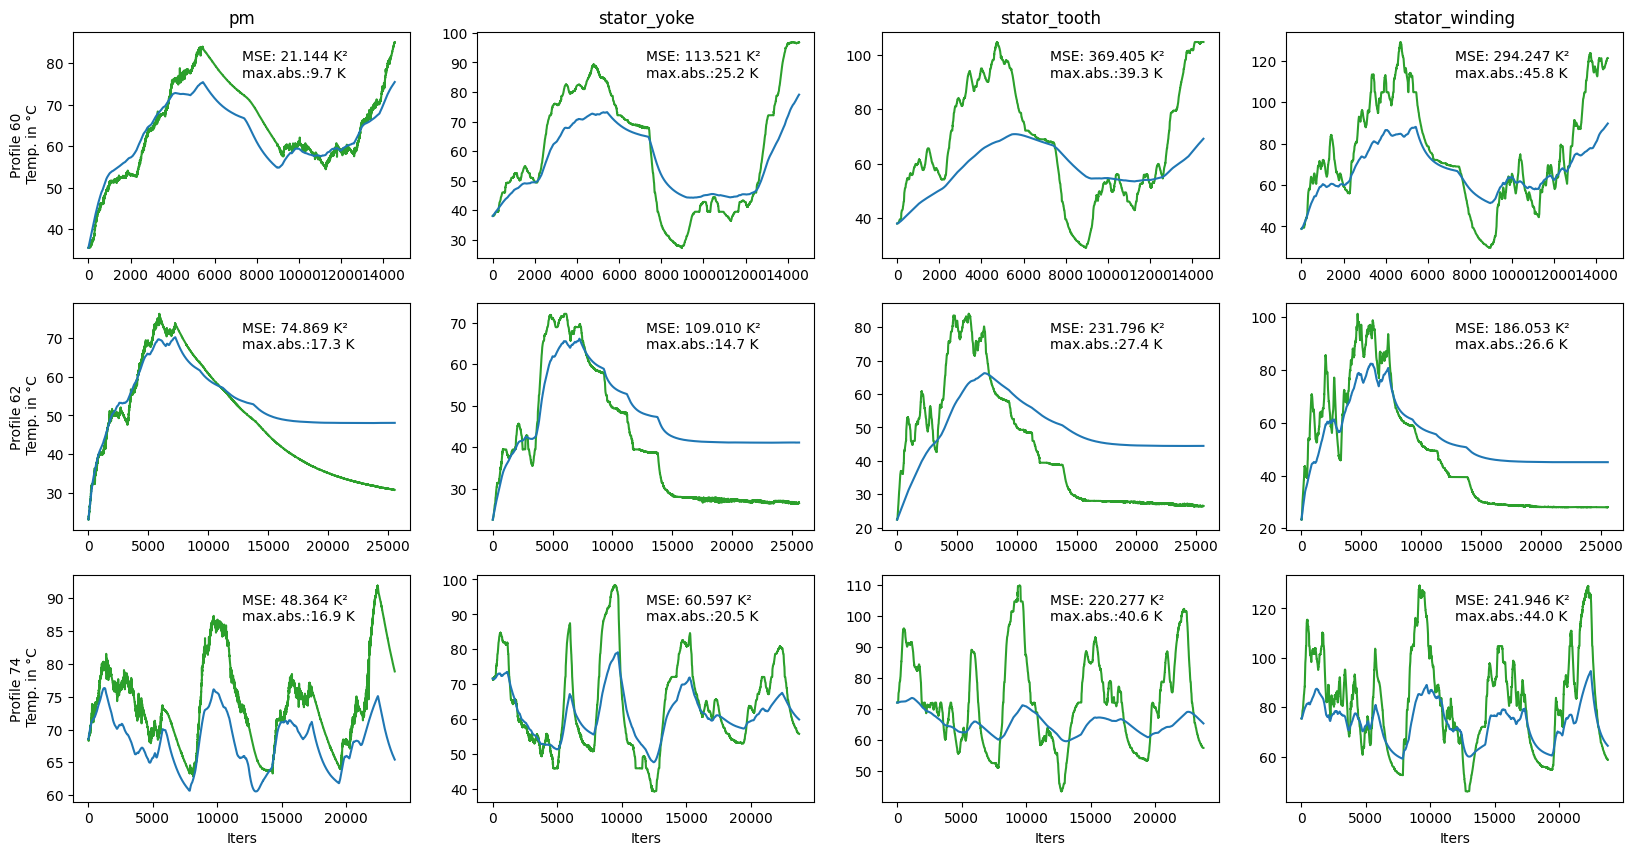

In [7]:
test_profiles = unrolled_test_profiles

fig, axes = plt.subplots(len(test_profiles), len(ds.target_cols), figsize=(20, 10))
for i, (pid, y_test) in enumerate(gtruth.groupby(ds.pid)):
    y_test *= 100
    profile_pred = 100*all_predictions_df.loc[all_predictions_df["profile_id"]==pid, ds.target_cols]
    profile_pred = profile_pred.values[:len(y_test), :]
    for j, col in enumerate(ds.target_cols):
        ax = axes[i, j]
        ax.plot(y_test.loc[:, col].reset_index(drop=True), color='tab:green')
        ax.plot(profile_pred[:, j], color='tab:blue')
        ax.text(x=0.5, y=0.8, 
                s=f'MSE: {((profile_pred[:, j] - y_test.loc[:, col])**2).sum() / len(profile_pred):.3f} K²\nmax.abs.:{(profile_pred[:, j]-y_test.loc[:, col]).abs().max():.1f} K',
                transform=ax.transAxes)
        if j == 0:
            ax.set_ylabel(f'Profile {pid}\n Temp. in °C')
        if i == len(test_profiles) - 1:
            ax.set_xlabel(f'Iters')
        elif i == 0:
            ax.set_title(col)
